# Deep Convolutional Generative Adversarial Network

This example builds DCGAN in Equinox, which is a Generative Adversarial Network (GAN) using convolutional layers in the discriminator and generator.

This example is an implementation based on the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

Authors: Alec Radford (alec@indico.io), Luke Metz (luke@indico.io), and Soumith Chintala (soumith@fb.com)

In [3]:
# imports

import jax

import jax.numpy as jnp
import optax

import torch
from typing import Union

import equinox as eqx

In [4]:
# Hyperparameters

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

batch_size = 32
epochs = 10

In [5]:
# Generator Model


class Generator(eqx.Module):
    conv_layers: list[Union[eqx.nn.ConvTranspose2d, eqx.nn.BatchNorm, jax.nn.relu]]
    output_layers: list[Union[eqx.nn.ConvTranspose2d, jax.nn.tanh]]

    def __init__(
        self, input_shape: int = 100, output_shape: tuple[int, int] = (64, 64, 3)
    ):
        self.conv_layers = [
            eqx.nn.ConvTranspose2d(
                in_channels=input_shape,
                out_channels=output_shape[0] * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            eqx.nn.BatchNorm(),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 8,
                out_channels=output_shape[0] * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 4,
                out_channels=output_shape[0] * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0] * 2,
                out_channels=output_shape[0],
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(),
            jax.nn.relu,
        ]

        self.output_layers = [
            eqx.nn.ConvTranspose2d(
                in_channels=output_shape[0],
                out_channels=output_shape[2],
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            jax.nn.tanh,
        ]

    def __call__(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        for layer in self.output_layers:
            x = layer(x)

        return x

In [6]:
# Discriminator Model


class Discriminator(eqx.Module):
    input_layers: list[Union[eqx.nn.Conv2d, eqx.nn.PReLU]]
    hidden_layers: list[Union[eqx.nn.Conv2d, eqx.nn.BatchNorm, eqx.nn.PReLU]]
    output_layers: list[Union[eqx.nn.Conv2d, jax.nn.sigmoid]]

    def __init__(
        self,
        input_shape: tuple[int, int, int] = (3, 64, 64),
    ):
        self.input_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[0],
                out_channels=input_shape[1],
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.PReLU(0.2),
        ]

        self.hidden_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[1],
                out_channels=input_shape[1] * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(input_shape[1] * 2),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 2,
                out_channels=input_shape[1] * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(input_shape[1] * 4),
            eqx.nn.PReLU(0.2),
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 4,
                out_channels=input_shape[1] * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            eqx.nn.BatchNorm(input_shape[1] * 8),
            eqx.nn.PReLU(0.2),
        ]

        self.output_layers = [
            eqx.nn.Conv2d(
                in_channels=input_shape[1] * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            jax.nn.sigmoid,
        ]

    def __call__(self, x):
        for layer in self.input_layers:
            x = layer(x)

        for layer in self.hidden_layers:
            x = layer(x)

        for layer in self.output_layers:
            x = layer(x)

        return x

In [7]:
# Adding the BCE loss function and the optimizers


@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))


@eqx.filter_jit
def make_step(model, x, y, optim, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


generator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)
discriminator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)

In [11]:
# loading the FGVC-Aircraft dataset using torchvision

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

data = torchvision.datasets.FGVCAircraft(
    root="./data", split="train", transform=transform, download=True
)
dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True, num_workers=2
)

100%|██████████| 2753340328/2753340328 [02:22<00:00, 19331463.27it/s]


Extracting ./data/fgvc-aircraft-2013b.tar.gz to ./data


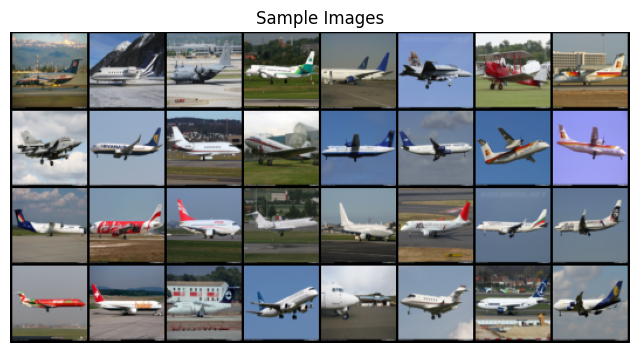

In [48]:
# plotting some training images

import matplotlib.pyplot as plt
import torchvision.utils as vutils

images = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(
    jnp.transpose(
        vutils.make_grid(images[0], padding=2, normalize=True).detach().numpy(),
        (1, 2, 0),
    )
);